<a href="https://colab.research.google.com/github/fnavab/APS360-project/blob/main/Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import scipy.ndimage.interpolation as inter
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
master_path = '/content/gdrive/My Drive/Colab Notebooks/'
folder = 'Project/Image_data/'

Mounted at /content/gdrive


In [ ]:
### LOAD BOUNDING BOXES FOR IMAGE CROPPING ###

# Import bounding boxes to dictionary

d = {}
with open(master_path+"/Project/list_bbox.txt") as f:
  for i, line in enumerate(f):
    if i != 0 and i != 1: # ignore first two lines
      (key, x1, y1, x2, y2) = line.split()

      #if "Acid_Wash_Ankle_Jeans" in key or "Athletic_Marled_Knit_Joggers" in key or "Basic_Crew_Neck_Tee" in key or "Button_Fly_Denim_Shorts" in key or "Contrast-Trimmed_Sweater" in key: # space saver for now...
      d[key] = (int(x1), int(y1), int(x2), int(y2))

print("Number of bounding boxes:", len(d))

# Find the max height and width of all images
# so that we can pad smaller images to be equal in size later on

max_h, max_w = 0, 0

for values in d.values():
  x1, y1, x2, y2 = values[0], values[1], values[2], values[3]
  
  h = y2-y1 # image height
  w = x2-x1 # image width

  if h > max_h:
    max_h = h
  if w > max_w:
    max_w = w

print("Max image dimensions:", max_h, max_w)

Number of bounding boxes: 289222
Max image dimensions: 299 299


In [ ]:
### MODIFY IMAGEFOLDER CLASS TO PRESERVE FILENAMES ###

# Need to overwrite default ImageFolder method in torchvision so that we can preserve the filename of the samples

class ImageFolderWithPaths(datasets.ImageFolder): # CREDIT: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
### INITIALIZING DATALOADERS ###

# Create separate datasets for all classes so we can check how many samples are in each class
transform = transforms.Compose([transforms.ToTensor()])

shirts = ImageFolderWithPaths(root=master_path+folder+"0_Shirt/", transform=transform)
shirts_loader = torch.utils.data.DataLoader(shirts, batch_size=1, shuffle=True)

jeans = ImageFolderWithPaths(root=master_path+folder+"1_Jeans/", transform=transform)
jeans_loader = torch.utils.data.DataLoader(jeans, batch_size=1, shuffle=True)

loungepants = ImageFolderWithPaths(root=master_path+folder+"2_Lounge pants/", transform=transform)
loungepants_loader = torch.utils.data.DataLoader(loungepants, batch_size=1, shuffle=True)

shorts = ImageFolderWithPaths(root=master_path+folder+"3_Shorts/", transform=transform)
shorts_loader = torch.utils.data.DataLoader(shorts, batch_size=1, shuffle=True)

skirt = ImageFolderWithPaths(root=master_path+folder+"4_Skirt/", transform=transform)
skirt_loader = torch.utils.data.DataLoader(skirt, batch_size=1, shuffle=True)

sweater = ImageFolderWithPaths(root=master_path+folder+"5_Sweater/", transform=transform)
sweater_loader = torch.utils.data.DataLoader(sweater, batch_size=1, shuffle=True)

dress = ImageFolderWithPaths(root=master_path+folder+"6_Dress/", transform=transform)
dress_loader = torch.utils.data.DataLoader(dress, batch_size=1, shuffle=True)

jacket = ImageFolderWithPaths(root=master_path+folder+"7_Jacket/", transform=transform)
jacket_loader = torch.utils.data.DataLoader(jacket, batch_size=1, shuffle=True)

In [ ]:
### CLASS SIZES ###

# These will be balanced later on through data augmentation
print("Shirts:", len(shirts_loader))
print("Jeans:", len(jeans_loader))
print("Lounge pants:", len(loungepants_loader))
print("Shorts:", len(shorts_loader))
print("Skirts:", len(skirt_loader))
print("Sweaters:", len(sweater_loader))
print("Dresses:", len(dress_loader))
print("Jackets:", len(jacket_loader))

Shirts: 37098
Jeans: 7155
Lounge pants: 10007
Shorts: 16646
Skirts: 14773
Sweaters: 11439
Dresses: 55231
Jackets: 20007


In [ ]:
### HELPER FUNCTION FOR IMAGE CROPPING ###

# Helper dict to truncate filenames
# filenames have varying prefix lengths depending on label
label_lengths = {}
label_lengths[0] = len("0_Shirt")
label_lengths[1] = len("1_Jeans")
label_lengths[2] = len("2_Lounge pants")
label_lengths[3] = len("3_Shorts")
label_lengths[4] = len("4_Skirt")
label_lengths[5] = len("5_Sweater")
label_lengths[6] = len("6_Dress")
label_lengths[7] = len("7_Jacket")

def crop_image(img, label, filename, max_h, max_w):
  
  #print("Original shape:", img.shape)
  img = img.permute(1, 2, 0) # rearrange tensor so colour channel is at the end
  #print("RGB channel moved:", img.shape)

  #print("Name:", filename)

  # in bbox file, filenames are formatted like this: img/Sheer_Pleated-Front_Blouse/img_00000001.jpg
  label_length = label_lengths[label]
  filename = "img" + filename[60+label_length:] # get rid of google drive prefix
  #print("Modified name:", filename)

  img_name = filename
  if img_name not in d:
    return (False, 0)
  x1, y1, x2, y2 = d[img_name] # get bbox values

  img_cropped = img[y1:y2, x1:x2, :3] # crop based on bbox values

  #print("Cropped shape:", img_cropped.shape)

  # create background image for uniformly-sized images
  bg = torch.zeros((max_h,max_w,3))

  # superimpose cropped image on background
  for z in range(img_cropped.shape[2]):
    for y in range(img_cropped.shape[1]):
      for x in range(img_cropped.shape[0]):
        bg[x][y][z] = img_cropped[x][y][z]

  # plot original and bounded side by side
  #f = plt.figure()
  #f.add_subplot(1,3, 1)
  #plt.imshow(img)
  #f.add_subplot(1,3, 2)
  #plt.imshow(img_cropped)
  #f.add_subplot(1,3, 3)
  #plt.imshow(bg)
  #plt.show(block=True)

  return (True, bg)

In [ ]:
### IMAGE CROPPING AND SAVING ###

# Set up empty lists to store processed data
processed_shirts, processed_jeans, processed_loungepants, processed_shorts = [], [], [], []
processed_skirts, processed_sweaters, processed_dresses, processed_jackets = [], [], [], []

In [ ]:
i=0
for images, labels, fname in shirts_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 0, filename, max_h, max_w) # crop image
  processed_shirts.append((processed_img, 0)) # add cropped image + label (hard coded)
  
  i+=1

  if i % 100 == 0:
    print(str(i), "images complete")

  if i > 1000:
    break

100 images complete
200 images complete
300 images complete
400 images complete
500 images complete
600 images complete
700 images complete
800 images complete
900 images complete
1000 images complete


In [ ]:
i=0
for images, labels, fname in jeans_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 1, filename, max_h, max_w) # crop image
  if processed_img[0] == True:
    processed_jeans.append((processed_img[1], 1)) # add cropped image + label (hard coded)
    i+=1

  if i % 100 == 0:
    print(str(i), "images complete")

  if i > 1000:
    break

100 images complete
200 images complete
300 images complete
400 images complete
500 images complete
600 images complete
700 images complete
800 images complete
900 images complete
1000 images complete


In [ ]:
i=0
for images, labels, fname in loungepants_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 2, filename, max_h, max_w) # crop image
  if processed_img[0] == True:
    processed_loungepants.append((processed_img[1], 2)) # add cropped image + label (hard coded)
    i+=1

  if i % 100 == 0:
    print(str(i), "images complete")

  if i > 1000:
    break

100 images complete
100 images complete
200 images complete
200 images complete
300 images complete
300 images complete
400 images complete
500 images complete
600 images complete
700 images complete
800 images complete
900 images complete
1000 images complete
1000 images complete


In [ ]:
i=0
for images, labels, fname in shorts_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 3, filename, max_h, max_w) # crop image
  if processed_img[0] == True:
    processed_shorts.append((processed_img[1], 3)) # add cropped image + label (hard coded)
    i+=1

  if i % 100 == 0:
    print(str(i), "images complete")

  if i > 1000:
    break

100 images complete
200 images complete
300 images complete
400 images complete
500 images complete
600 images complete
700 images complete
800 images complete
900 images complete
1000 images complete


In [ ]:
i=0
for images, labels, fname in skirt_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 4, filename, max_h, max_w) # crop image
  if processed_img[0] == True:
    processed_skirts.append((processed_img[1], 4)) # add cropped image + label (hard coded)
    i+=1
  
  if i % 100 == 0:
    print(str(i), "images complete")

  if i > 1000:
    break

100 images complete
200 images complete
300 images complete
400 images complete
500 images complete
600 images complete
700 images complete
800 images complete
900 images complete
1000 images complete


In [ ]:
i=0
for images, labels, fname in sweater_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 5, filename, max_h, max_w) # crop image
  if processed_img[0] == True:
    processed_sweaters.append((processed_img[1], 5)) # add cropped image + label (hard coded)
    i+=1

  if i % 100 == 0:
    print(str(i), "images complete")

  if i > 1000:
    break

100 images complete
200 images complete
300 images complete
400 images complete
500 images complete
600 images complete
700 images complete
800 images complete
900 images complete
1000 images complete


In [ ]:
i=0
for images, labels, fname in dress_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 6, filename, max_h, max_w) # crop image
  if processed_img[0] == True:
    processed_dresses.append((processed_img[1], 6)) # add cropped image + label (hard coded)
    i+=1

  if i % 100 == 0:
    print(str(i), "images complete")

  if i > 1000:
    break

100 images complete
200 images complete
300 images complete
400 images complete
500 images complete
600 images complete
700 images complete
800 images complete
900 images complete
1000 images complete


In [ ]:
i=0
for images, labels, fname in jacket_loader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, 7, filename, max_h, max_w) # crop image
  if processed_img[0] == True:
    processed_jackets.append((processed_img[1], 7)) # add cropped image + label (hard coded)
    i+=1

  if i % 100 == 0:
    print(str(i), "images complete")

  if i > 1000:
    break

100 images complete
200 images complete
300 images complete
400 images complete
500 images complete
600 images complete
700 images complete
800 images complete
900 images complete
1000 images complete


In [ ]:
# Save processed images
all_images = processed_shirts + processed_jeans + processed_loungepants + processed_shorts + processed_skirts + processed_sweaters + processed_dresses + processed_jackets
torch.save(all_images, "/content/gdrive/My Drive/Colab Notebooks/Project/APS360 GROUP/combined_images.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


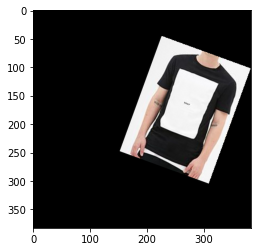

In [ ]:
### DATA AUGMENTATION ###

# takes in a list of processed images and returns a new list of rotated and flipped image
def augment_photos(processed_imgs):
  flipped_and_rotated_imgs = []
  for i in range(len(processed_imgs)):
    angle = np.random.randint(-25, 25)
    rotated_img = inter.rotate(processed_imgs[i][0].numpy(), angle)
    flipped_img = np.fliplr(rotated_img)
    flipped_and_rotated_imgs.append(flipped_img)
  return flipped_and_rotated_imgs

flipped_and_rotated_imgs = augment_photos(processed_tshirts) # test on t-shirts
plt.imshow(flipped_and_rotated_imgs[0])

In [ ]:
# takes in a list of processed images (with background)
# will add uniform noise to both the picture and background
import copy
def add_noise(processed_imgs):
  noise = 0.1
  noisy_image = copy.deepcopy(processed_imgs)

# can change z values to only change red, blue or green
  for z in range(3):
    for y in range(processed_imgs.shape[1]):
      for x in range(processed_imgs.shape[0]):
        noisy_image[x][y][z] = processed_imgs[x][y][z] + noise

  return noisy_image

x = add_noise(flipped_and_rotated_imgs[0])
plt.imshow(x)

In [ ]:
clothing_images = torch.load("/content/gdrive/My Drive/Colab Notebooks/Project/APS360 GROUP/combined_images.pt")
print(type(clothing_images))

<class 'list'>


In [ ]:
### DATA SPLITTING ###
# Get the list of indices to sample from
indices = list(range(len(clothing_images)))

# Split into train, validation, and test (60/20/20)
np.random.seed(1000) #fixed numpy random seed for reproducible shuffling
np.random.shuffle(indices)
train_split = int(len(indices) * 0.6) #split at 60% for 60/20/20 ratio
val_split = int(len(indices) * 0.2) + train_split

train_indices, val_indices, test_indices = indices[:train_split], indices[train_split:val_split], indices[val_split:]

# Create data loaders for train, validation, and test sets
batch_size=32

train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(clothing_images, batch_size=batch_size,
                                            num_workers=1, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(clothing_images, batch_size=batch_size,
                                          num_workers=1, sampler=val_sampler)

test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(clothing_images, batch_size=batch_size,
                                          num_workers=1, sampler=test_sampler)

torch.utils.data.dataloader.DataLoader
<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


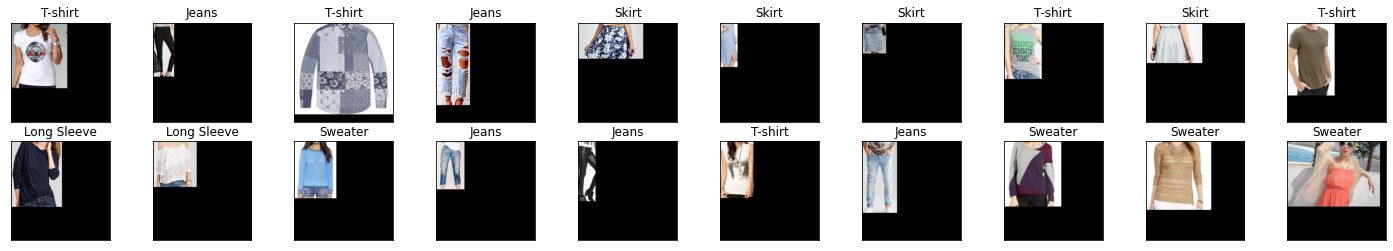

In [ ]:
# obtain one batch of training images
print(type(train_loader))
dataiter = iter(train_loader)
print(type(dataiter))
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
classes = ["T-shirt", "Long Sleeve", "Jeans", "Lounge Pants", "Shorts", "Skirt", "Sweater", "Dress", "Jacket"]
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title(classes[labels[idx]])